
Testing for N = 20
Solution: [0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0]
Peak Memory Used: 70.55 MB
Time Taken: 11.138932 seconds

Testing for N = 40
Solution: [0 0 0 0 0 0 1 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0
 0 0 0]
Peak Memory Used: 52.31 MB
Time Taken: 10.245996 seconds

Testing for N = 60
Solution: [0 0 0 0 0 0 0 0 1 0 0 1 1 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0]
Peak Memory Used: 52.36 MB
Time Taken: 10.415744 seconds

Testing for N = 80
Solution: [0 1 1 0 0 0 0 1 1 1 1 0 0 0 0 1 0 1 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0]
Peak Memory Used: 52.48 MB
Time Taken: 16.284770 seconds

Testing for N = 100
Solution: [0 0 1 1 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0
 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 1 1 1 0 1 0 0 0 0 1 0 0 0 0 0
 0 0 0 1 1 0 0 1 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0]
Peak 

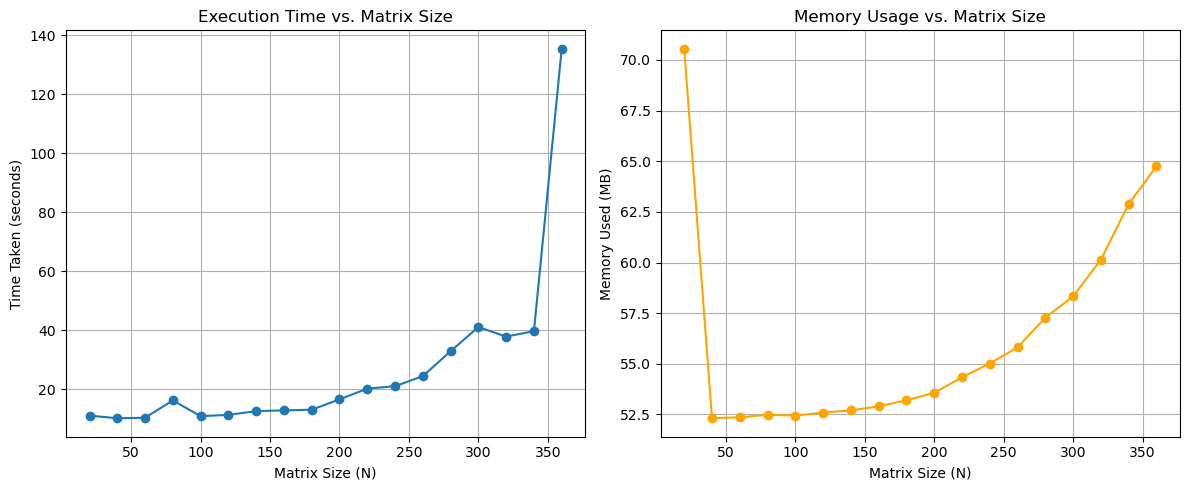

In [6]:
import dimod
from dwave.system import DWaveSampler, EmbeddingComposite
import tracemalloc
import time
import numpy as np
from scipy.sparse import csc_matrix, random as sparse_random
import matplotlib.pyplot as plt

def qubosolver(A, b):
    # Start tracing memory allocations
    tracemalloc.start()
    start_time = time.time()

    # Keep A sparse
    A = csc_matrix(A)

    bqm = dimod.BinaryQuadraticModel.empty(dimod.BINARY)

    # Add variables
    bqm.add_variables_from({i: b[i] for i in range(len(b))})

    row, col = A.nonzero()
    for i, j in zip(row, col):
        if i != j:
            bqm.add_interaction(i, j, A[i, j])

    # Use D-Wave's quantum sampler
    sampler = EmbeddingComposite(DWaveSampler(token='DEV-2df6769d96a5ddaec4b4e037d3a7a92833582e9c'))
    response = sampler.sample(bqm, num_reads=100)

    best_sample = response.first.sample
    sol_sample = np.fromiter(best_sample.values(), dtype=int)

    end_time = time.time()
    # Get the current and peak memory usage
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    # Convert bytes to MB
    memory_used = peak / (1024 ** 2)
    time_taken = end_time - start_time

    print(f"Solution: {sol_sample}")
    print(f"Peak Memory Used: {memory_used:.2f} MB")
    print(f"Time Taken: {time_taken:.6f} seconds")

    return sol_sample, memory_used, time_taken

def test_scalability():
    Ns = []
    times = []
    memories = []
    max_N = 3000   # Adjusted based on D-Wave hardware limitations
    step = 20   # Increment size for N
    density = 0.01  # Density of the sparse matrix

    for N in range(20, max_N + 1, step):
        print(f"\nTesting for N = {N}")
        try:
            # Generate a random sparse binary matrix A
            A = sparse_random(N, N, density=density, format='csc', data_rvs=np.ones).astype(int)

            # Ensure symmetry if required (assuming A should be symmetric)
            A = A + A.T
            A.data[:] = 1  # Ensure all non-zero entries are 1

            # Generate a random binary vector b
            b = np.random.randint(0, 2, size=N)

            # Run the qubosolver
            _, memory_used, time_taken = qubosolver(A, b)

            # Record the results
            Ns.append(N)
            times.append(time_taken)
            memories.append(memory_used)

        except Exception as e:
            print(f"An error occurred: {e}")
            break

    # Plotting the results
    plt.figure(figsize=(12, 5))

    # Plot for Execution Time
    plt.subplot(1, 2, 1)
    plt.plot(Ns, times, marker='o')
    plt.title('Execution Time vs. Matrix Size')
    plt.xlabel('Matrix Size (N)')
    plt.ylabel('Time Taken (seconds)')
    plt.grid(True)

    # Plot for Memory Usage
    plt.subplot(1, 2, 2)
    plt.plot(Ns, memories, marker='o', color='orange')
    plt.title('Memory Usage vs. Matrix Size')
    plt.xlabel('Matrix Size (N)')
    plt.ylabel('Memory Used (MB)')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Run the scalability test
test_scalability()


Running for matrix size 10x10
Solution: [1 1 1 1 0 0 1 0 1 1]
Memory used: 3.10 MB (Peak: 33.03 MB)
Time: 19.718619 seconds
Running for matrix size 50x50
Solution: [0 0 0 0 1 1 0 1 1 0 1 1 0 1 0 1 0 0 0 1 0 1 1 0 0 1 0 0 1 0 0 1 0 0 0 0 1
 0 0 1 0 1 1 0 0 0 0 0 0 1]
Memory used: 0.52 MB (Peak: 30.69 MB)
Time: 17.585014 seconds
Running for matrix size 100x100
Solution: [0 1 1 1 1 0 1 0 0 1 1 1 0 0 0 0 1 1 0 0 0 0 0 1 1 1 0 0 0 0 0 1 1 0 0 0 1
 0 0 0 0 1 0 0 0 0 0 1 1 1 1 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 1 1 0 0 0 0
 0 0 0 1 1 0 1 0 0 1 0 0 1 0 1 0 1 0 0 1 1 0 0 0 1 1]
Memory used: 0.52 MB (Peak: 30.69 MB)
Time: 17.021498 seconds
Running for matrix size 500x500
Solution: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0
 1 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 1 1 1 0 0 0 0 0 1 0
 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0 1 0
 0 0 0 0 0 1 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 0 1 0 1 0 1 0
 0 0 1 1 1 0 0 0 1 0 

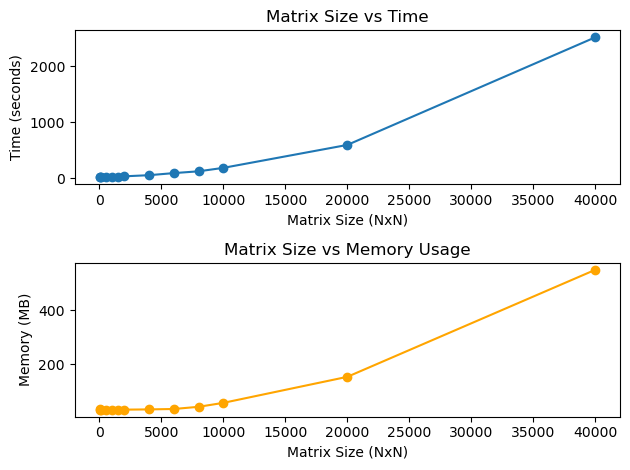

In [1]:
import numpy as np
import time
import tracemalloc
import matplotlib.pyplot as plt
from scipy.sparse import random as sparse_random
from scipy.sparse import csc_matrix
import dimod
from dwave.system import LeapHybridSampler
import os

os.environ['DWAVE_API_TOKEN'] = 'DEV-031741f1792495e220d4d55aeb72ab7961cc16cd'

def qubosolverHr(A, b):
    tracemalloc.start()
    start_time = time.time()
    A = csc_matrix(A)
    bqm = dimod.BinaryQuadraticModel.empty(dimod.BINARY)
    bqm.add_variables_from({i: b[i] for i in range(len(b))})
    row, col = A.nonzero()  # Get non-zero entries in the matrix A
    for i, j in zip(row, col):
        if i != j:  
            bqm.add_interaction(i, j, A[i, j])

    
    sampler = LeapHybridSampler()
    response = sampler.sample(bqm)
    best_sample = response.first.sample
    sol_sample = np.fromiter(best_sample.values(), dtype=int)

    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    memory_used_mb = current / (1024 ** 2)
    peak_memory_used_mb = peak / (1024 ** 2)
    end_time = time.time()

    # Calculate time taken
    time_taken = end_time - start_time

    # Output solution and performance details
    print(f"Solution: {sol_sample}")
    print(f"Memory used: {memory_used_mb:.2f} MB (Peak: {peak_memory_used_mb:.2f} MB)")
    print(f"Time: {time_taken:.6f} seconds")

    return sol_sample, time_taken, peak_memory_used_mb


def test_scalability():
    matrix_sizes = []
    memory_usage = []
    time_taken = []
    sizes = [10, 50, 100, 500, 1000, 1500, 2000 ,4000, 6000, 8000, 10000 ,20000, 40000, 60000, 80000 ,100000, 120000, 140000, 160000, 180000, 200000]

    try:
        for size in sizes: 
            print(f"Running for matrix size {size}x{size}")
            A = sparse_random(size, size, density=0.01, format='csc', dtype=np.float64)
            A.data = np.ones_like(A.data) 
            b = np.random.randn(size)  # Random linear terms

            sol, t, memory = qubosolverHr(A, b)
            matrix_sizes.append(size)
            time_taken.append(t)
            memory_usage.append(memory)

    except KeyboardInterrupt:
        print("Process interrupted by user.")
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        plt.figure()
        plt.subplot(2, 1, 1)
        plt.plot(matrix_sizes, time_taken, marker='o', label='Time (seconds)')
        plt.xlabel('Matrix Size (NxN)')
        plt.ylabel('Time (seconds)')
        plt.title('Matrix Size vs Time')

        plt.subplot(2, 1, 2)
        plt.plot(matrix_sizes, memory_usage, marker='o', label='Peak Memory Usage (MB)', color='orange')
        plt.xlabel('Matrix Size (NxN)')
        plt.ylabel('Memory (MB)')
        plt.title('Matrix Size vs Memory Usage')

        plt.tight_layout()
        plt.show()

test_scalability()


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import psutil
import time
from scipy.sparse import random as sparse_random, csc_matrix
from dimod import SimulatedAnnealingSampler, BinaryQuadraticModel
import dimod
import tracemalloc

def qubosolver(A, b):
    # Keep A sparse
    A = csc_matrix(A)
    bqm = BinaryQuadraticModel.empty(dimod.BINARY)

    # Vectors for efficiency 
    bqm.add_variables_from({i: b[i] for i in range(len(b))})

    row, col = A.nonzero()  
    for i, j in zip(row, col):
        if i != j:  
            bqm.add_interaction(i, j, A[i, j])

    sampler = SimulatedAnnealingSampler()
    response = sampler.sample(bqm, num_reads=100)

    best_sample = response.first.sample
    sol_sample = np.fromiter(best_sample.values(), dtype=int)  



    return sol_sample

import numpy as np
import scipy.sparse as sp
import time
import tracemalloc
import matplotlib.pyplot as plt

def generate_sparse_binary_matrix(size, density=0.01):
    """Generate a sparse binary matrix of given size with specified density."""
    return sp.random(size, size, density=density, format='csr', dtype=np.int8).astype(bool)

def qubosolver_scalability_test(qubosolver, sizes):
    times = []
    memory_usages = []
    
    for size in sizes:
        # Generate sparse binary matrix A and vector b
        A = generate_sparse_binary_matrix(size)
        b = np.random.randint(2, size=size).astype(np.int8)
        
        # Track memory usage and execution time
        tracemalloc.start()
        start_time = time.perf_counter()
        
        # Run the QUBO solver
        qubosolver(A, b)
        
        # Calculate time and memory
        end_time = time.perf_counter()
        current, peak = tracemalloc.get_traced_memory()
        
        times.append(end_time - start_time)
        memory_usages.append(peak / 1024 ** 2)  # Convert bytes to MB
        
        tracemalloc.stop()
    
    # Plotting
    plt.figure(figsize=(10, 5))

    # Plot time vs matrix size
    plt.subplot(1, 2, 1)
    plt.plot(sizes, times, marker='o')
    plt.xlabel('Matrix Size (n x n)')
    plt.ylabel('Time (seconds)')
    plt.title('Time vs Matrix Size')

    # Plot memory usage vs matrix size
    plt.subplot(1, 2, 2)
    plt.plot(sizes, memory_usages, marker='o')
    plt.xlabel('Matrix Size (n x n)')
    plt.ylabel('Memory Usage (MB)')
    plt.title('Memory Usage vs Matrix Size')

    plt.tight_layout()
    plt.show()
    
    return {'sizes': sizes, 'times': times, 'memory_usages': memory_usages}

sizes = [50, 100, 200, 300, 400, 500] 
qubosolver_scalability_test(qubosolver, sizes)


Execution interrupted by the user.


Smallest Eigenvalue: -1.9638868670159402
Corresponding Eigenvector: [ 1.04647953e-02  2.50675756e-03  6.56174379e-02  4.38419693e-02
 -7.90814674e-04  1.18288076e-02  1.77521371e-02 -2.89088717e-02
 -6.32242907e-02 -6.30535844e-02  1.05094473e-02  1.73221898e-02
 -8.45812094e-03 -1.02239026e-02  6.99815665e-03  1.17019524e-02
 -7.52279436e-02  3.01895272e-03 -1.54151168e-03  3.59033154e-02
 -3.64761442e-02 -7.15896436e-03 -1.90946608e-02 -2.25424153e-02
  3.26953760e-02 -5.93209587e-04 -1.13922662e-02  4.64307393e-02
  6.75397085e-02  3.61880152e-02 -1.90028203e-02 -8.88145302e-02
  1.12223700e-01  7.90180304e-03 -8.59781780e-03 -3.05148340e-04
 -1.44378341e-02 -2.63210048e-03 -2.32728951e-02  2.33290241e-03
 -2.12625969e-02 -6.35551799e-02 -3.15641037e-03 -1.08154956e-02
  3.66028553e-02 -9.60067715e-03  5.94063765e-03  1.60779992e-01
 -3.28946501e-02  2.55396235e-02 -2.50926087e-03 -5.55780058e-03
 -2.78745208e-02  1.73395324e-02  7.80901399e-03  1.34936620e-02
 -2.01125184e-02  7.44